<!-- Title: -->
<div align="center">
  <h1> Supplementary Material for IBM Quantum Spring Challenge 2022 </h1>
</div>
<br>



---
This notebook presents the step-by-step derivation of the quantum circuits provided as solutions to the first challenge. 

The useful linear algebra identities for quantum circuits are now in the [quantum-circuit-theory](https://github.com/QuCAI-Lab/quantum-circuit-theory/blob/dev/notebooks/algebraic_identities.ipynb) dedicated repository to avoid information overload.

Qiskit little-endian convention is now in the [here](https://github.com/QuCAI-Lab/quantum-circuit-theory/blob/dev/notebooks/08_circuit_identities.ipynb).

---

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/python" width="45" hspace="0px" vspace="0px"></a> Importing dependencies


In [2]:
import numpy as np
import sympy as sym
from sympy import exp # Symbolic exponentiation.
from scipy.linalg import expm # Numerical exponentiation.
from sympy.physics.quantum import TensorProduct, OuterProduct

from qiskit import Aer, QuantumRegister, QuantumCircuit, assemble, execute
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z

import pylatexenc # Required to use 'MatplotlibDrawer'.

# Numpy
- Defining the eigenstates, projector operators, and gates that will be used to verify the identites.

In [3]:
'''1-qubit gates SU(2):'''
sigma0 = np.identity(2) # Matrix of the identity gate.
sigma1 = np.array([[0,1],[1,0]], dtype=(np.float32)) # Matrix of the Pauli-X gate that performs a Pi radian rotation around the x-axis.
sigma2 = np.array([[0,-1j],[1j,0]], dtype=(np.complex64)) # Matrix of the Pauli-Y gate = iXZ.
sigma3 = np.array([[1,0],[0,-1]], dtype=(np.float32)) # Matrix of the Pauli-Z gate = P(pi).
had = (1/np.sqrt(2))*np.array([[1,1],[1,-1]]) # Matrix of the Hadamard gate that performs a Pi radian rotation around an axis between the x and z axes.
phase = np.array([[1,0],[0,1j]]) #  Matrix of the Phase gate S = P(pi/2) = square-root of Pauli-Z.

'''2-qubit gates SU(4):'''
XX = np.kron(sigma1,sigma1) # Matrix of the XX gate.
YY = np.kron(sigma2,sigma2) # Matrix of the YY gate.

'''Array dimensions:'''
sigma0.shape, sigma1.shape, sigma2.shape, sigma3.shape, had.shape, phase.shape, XX.shape, YY.shape

((2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (4, 4), (4, 4))

# Deriving Quantum Circuits

- $ZZ(t)$, $XX(t)$, and $YY(t)$ gates.

## Short notes on linear algebra



Recall that Pauli operators $X, Y,$ and $Z$ are all represented by matrices that are both Hermitian and Unitary and, therefore, Involutory. Since they are Involutory, their eigenvalues are $\pm 1$. Moreover, Hermitian and Unitary matrices are Normal matrices. The converse is not true, i.e, Normal matrices are not always Hermitian and Unitary. A Normal matrix is Unitary iff all of its eigenvalues (the matrix spectrum) lie on the unit circle of the complex plane, i.e, they have modulus (absolute value) equal to one ($|\lambda|=1$), and hence they can be written in the form $\lambda=e^{i\theta}$ for some real-valued number $\theta$. And a Normal matrix is Hermitian iff all of its eigenvalues are real ($\lambda=\lambda^*$).

**Spectral decomposition theorem for Normal matrices** *Any Normal operator $\hat{\mathcal{O}}$ on a vector space $V$ of dimension $\dim V=d$ is unitarily diagonalizable with respect to some orthonormal basis for $V$. Conversely, any unitarily diagonalizable operator is normal.*

It follows that an operator is Normal iff it is unitarily diagonalizable. Therefore, any Normal operator has a spectral (eigenvalue) decomposition in terms of the outer product representation, and in the basis of its eigenvectors, of the form:

$$ \hat{O} = \sum_{j=1}^{d}= o_j P_{o_j} = \sum_{j=1}^{d} o_j |o_j \rangle \langle o_j|.$$

Where:

- $o_j$ and $P_{o_j}$ are the corresponding eigenvalue and projector operator of the observable $\hat{O}$, respectively. 

- $\{o_j\}|_{j=1}^d$ is a basis set of $d$ linearly independent orthonormal eigenvectors $|o_j\rangle$ of $\hat{O}$ with eigenvalue $o_j$.

Note that:

$$ \Bigg( \sum_{j=1}^{d} o_j |o_j \rangle \langle o_j| \Bigg) |o_k \rangle =  \sum_{j=1}^{d} o_j |o_j \rangle \delta_{jk}= o_k |o_k \rangle = \hat{O} |o_k \rangle.$$

**Note:** the above theorem does not imply that any diagonalizable operator is Normal, this is only true for `unitary diagonalization`. There are matrices which are not Normal, but are diagonalizable by orthogonal operators (`orthogonal diagonalization`). See the `spectral theorem for Symmetric matrices` for more information.

Let $A \in M^{n,n}$ be a square matrix of dimension $n$x$n$.

- 1) $A$ is `unitary diagonalizable` if and only if $A$ is Normal: $AA^{\dagger}=A^{\dagger}A$.

- 2) $A$ is `orthogonally diagonalizable` if and only if $A$ is symmetric: $A=A^{T}$.

Given the spectral decomposition theorem, it is possible to write the operator function (matrix function) on a Normal matrix $\hat{O}$ as follows:

$$f(\hat{O})= \sum_j f(o_j) |o_j\rangle \langle o_j|,$$

which is equivalent to (after writing $\hat{O} = UDU^{\dagger}$)

\begin{eqnarray}
f(\hat{O}) = Uf(D)U^{\dagger}.
\end{eqnarray}

For the exponential function over the field $\mathbb{C}^n$ of the complex numbers, this becomes:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|.$$

To see this is true, recall that the eigenvalues of a matrix are multiplied by a scalar when the matrix is multiplied by the same scalar, while the eigenvectors are left unchanged. One can extend this identity to a tensor product of Normal operators noting that `the tensor product of two Hermitian operators is another Hermitian operator`. Recall that Hermitian and Unitary operators are also Normal operators and, therefore, they also have a spectral decomposition in terms of the outer product representation.

## $ZZ(t)$ gate




In this section, the following circuit for the ZZ(t) gate will be verified:

$$ZZ(t) \equiv e^{-itZ \otimes Z} = CX^{01} \big(\mathbb{I} \otimes R_z (2t)\big) CX^{01} = CX^{01} \big(\mathbb{I} \otimes e^{-itZ} \big) CX^{01}.$$

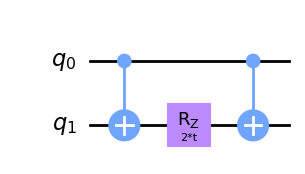

In [4]:
# Circuit for the ZZ(t) gate:

'''
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
'''

t = Parameter('t')

qc = QuantumCircuit(2, name='ZZ')
qc.cnot(0,1) # CX^{01}.
qc.rz(2 * t, 1) # R_z(2t).
qc.cnot(0,1) # CX^{01}.
qc.draw(output='mpl') # '!pip install pylatexenc' library is required to use 'MatplotlibDrawer'.

### Obtaining the ZZ(t) gate via spectral decomposition theorem

Recall that a general single-qubit standard rotation gate can be written as:

$$ R_{\hat{n}}(\theta) \doteq e^{\pm i(\hat{n} \cdot \vec{\sigma})\theta /2}= \cos(\theta/2) I \pm i \sin(\theta/2)(\hat{n}\cdot \hat{\sigma}),$$

and after defining $\theta \doteq 2t$, one has

\begin{eqnarray}
RZ(2t) \equiv R_z(2t)&=& R_{(0,0,1)}(2t) \doteq \exp(- iZ2t/2) = e^{-itZ} 
= cos(t)I -isin(t)Z = 
\begin{bmatrix} e^{- it} & 0 \\0 &  e^{it}
\end{bmatrix} = e^{- it}|0 \rangle\langle 0| + e^{it} |1 \rangle\langle 1|.
\end{eqnarray}

With that, the $e^{-itZZ}$ gate (a.k.a [RZZ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html)(2t)) can be written as follows:

\begin{equation}
R_{zz}(2t)= \exp(-it Z\otimes Z)=cos\left(t\right)(\mathbb{I}_2\otimes \mathbb{I}_2)-isin\left(t\right)(Z\otimes Z).
\end{equation}

The $e^{-itZ\otimes Z}$ gate is already diagonalized in the canonical basis a.k.a $Z$-basis. To see this is true, recall that Pauli operators are Normal operators, therefore, one can write the following spectral decomposition for the Pauli-$Z$ gate in the canonical basis: 

$$Z=\sum_{j=1}^{d} z_j |z_j \rangle \langle z_j|=|0\rangle\langle 0|-|1\rangle\langle 1|.$$

Note that the eigenvalues are $o_j = \pm 1$, since Pauli operators are represented by Involutory matrices. With that, one then has 

\begin{eqnarray}
Z\otimes Z &=& (|0\rangle\langle 0|-|1\rangle\langle 1|)\otimes(|0\rangle\langle 0|-|1\rangle\langle 1|) \tag{ZZ1}\\
&=& (|0\rangle\langle 0|) \otimes (|0\rangle\langle 0|) - (|0\rangle\langle 0|) \otimes (|1\rangle\langle 1|) - (|1\rangle\langle 1|) \otimes (|0\rangle\langle 0|) + (|1\rangle\langle 1|)\otimes(|1\rangle\langle 1|) \tag{ZZ2}\\
&=&|00\rangle\langle 00|-|01\rangle\langle 01|-|10\rangle\langle 10|+|11\rangle\langle 11| \tag{ZZ3} \\
&=& 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & -1 & 0 & 0 \\ 
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1  
\end{bmatrix}.
\end{eqnarray}

- Eq. ($ZZ2$) was obtained from Eq. ($ZZ1$) using the distributive property for matrices:

$$(A+B) \otimes (C+D)=A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- Eq. ($ZZ3$) was obtained from Eq. ($ZZ2$) using:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle\langle cd|.$$

Finally, 

\begin{eqnarray}
e^{-itZ \otimes Z}&=&e^{-it}|00\rangle\langle 00|+ e^{it}|01\rangle\langle 01|+ e^{it}|10\rangle\langle 10|+e^{-it}|11\rangle\langle 11|\tag{ZZ4} \\
&=&e^{-it}\bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\bigg)+e^{it}\bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\bigg) \\
&=& 
\begin{bmatrix} 
e^{-it} & 0 & 0 & 0 \\ 
0 & e^{it} & 0 & 0 \\ 
0 & 0 & e^{it} & 0 \\ 
0 & 0 & 0 & e^{-it}  
\end{bmatrix}.
\end{eqnarray}

- Eq. ($ZZ4$) is the result of acting an operator function (in this case $e^{i\theta \hat{O}}$) on a Normal matrix (in this case $Z\otimes Z$) represented by its spectral decomposition, according to:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|.$$

In another perspective, when the matrix is diagonal, the operator function acts on its diagonal entries.

### Obtaining the ZZ(t) gate via parity trick

- Computing the parity information by acting with the $ZZ$ operator.


To build quantum circuits corresponding to unitary evolution operators from exponentials of the form $U=e^{-i\hat{H}\Delta t}$, one can use the parity trick (see Ref. [[1](#ref1)], Sec. 4.7.3). In this case, one can obtain Eq. ($ZZ4$) by computing the parity information, as follows:

\begin{eqnarray}
(Z\otimes Z)|00\rangle &=& |00\rangle, \\
(Z\otimes Z)|10\rangle &=& -|10\rangle, \\
(Z\otimes Z)|01\rangle &=& -|01\rangle, \\
(Z\otimes Z)|11\rangle &=& |11\rangle. \\
\end{eqnarray}

One can see that a minus sign (phase) is introduced whenever the basis state has odd parity (01 or 10). Therefore, in the computational basis, a phase shift will be applied to the system according to $e^{i\Delta t}$ if the parity of the $n$ qubits in the computational basis is odd, otherwise, the phase shift will be $e^{-i\Delta t}$ if the parity is even (see Ref. [[1](#ref1)], Sec. 4.7.3). With this result, one can write:

\begin{eqnarray}
e^{-itZ \otimes Z} = e^{-it} |00\rangle\langle 00| + e^{it} |01\rangle\langle 01| + e^{it} |10 \rangle\langle 10| + e^{-it} |11 \rangle\langle 11|.
\end{eqnarray}

### Implementing the parity computation circuit

The above circuit can be obtained using the parity trick, where the first CNOT gate (a.k.a CX) computes the parity, and the second CNOT gate uncomputes the operation, since the CNOT gate is both a Unitary and Hermitian operator ($CX \cdot CX = CX \cdot CX^{\dagger} = \mathbb{I}$).



\begin{eqnarray}
CX^{01}\big(\mathbb{I} \otimes R_z(2t)\big)CX^{01} =
CX^{01}\big(\mathbb{I} \otimes e^{-itZ}\big)CX^{01},
\end{eqnarray}

where it was used $RZ(2t) = e^{-itZ}$.

Using the equation for a generic CU gate, one can write $CX^{01} = \mathbb{I} \otimes |0\rangle\langle 0\rangle + X \otimes |1 \rangle \langle 1|$. However, in textbook convention the CNOT gate reads $CX^{01}=|0\rangle\langle 0|\otimes \mathbb{I} +|1\rangle\langle 1|\otimes X$. One then has

\begin{eqnarray}
CX^{01}\big(\mathbb{I} \otimes e^{-itZ}\big)CX^{01}=CX^{01}\big( \mathbb{I} \otimes e^{-itZ}\big)\big(|0\rangle\langle 0|\otimes \mathbb{I}  +|1\rangle\langle 1|\otimes X \big).
\end{eqnarray}

From here, the distributive property of matrix multiplication over matrix addition yelds:

$$\big(\mathbb{I}\otimes e^{-itZ}\big)\big(|0\rangle\langle 0|\otimes \mathbb{I} +|1\rangle\langle 1|\otimes X \big) = \big(\mathbb{I}\otimes e^{-itZ}\big) \big(|0\rangle\langle 0|\otimes \mathbb{I} \big) + \big(\mathbb{I} \otimes e^{-itZ}\big)\big(|1\rangle\langle 1|\otimes X \big).$$

Using $(A\otimes B)\cdot(C\otimes D)=A\cdot C\otimes B\cdot D$, the right hand side becomes:

$$\Bigg[(\mathbb{I} \cdot |0\rangle\langle 0|) \otimes (e^{-itZ} \cdot \mathbb{I})\Bigg] + \Bigg[ (\mathbb{I} \cdot |1\rangle\langle 1|) \otimes (e^{-itZ} \cdot X) \Bigg] = \Bigg(|0\rangle\langle 0|\otimes e^{-itZ} \Bigg) + \Bigg(|1\rangle\langle 1|\otimes e^{-itZ}X \Bigg) .$$ 

With that, one then has:

\begin{eqnarray}
CX^{01}\bigg(\mathbb{I}\otimes e^{-itZ}\bigg)CX^{01} &=& CX^{01}\bigg(|0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes e^{-itZ}X \bigg) = \bigg(|0\rangle\langle 0|\otimes \mathbb{I} +|1\rangle\langle 1|\otimes X \bigg)\bigg(|0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes e^{-itZ}X \bigg).
\end{eqnarray}

Once again, applying the distributive property over matrix addition, the last term becomes

\begin{eqnarray}
CX^{01}\bigg(\mathbb{I}\otimes e^{-itZ}\bigg)CX^{01} &=& \bigg(|0\rangle\langle 0|\otimes \mathbb{I} \Bigg)\bigg(|0\rangle\langle 0|\otimes e^{-itZ} \Bigg)+\bigg(|0\rangle\langle 0|\otimes \mathbb{I} \Bigg)\bigg(|1\rangle\langle 1|\otimes e^{-itZ}X \Bigg)\\
&+&\bigg(|1\rangle\langle 1|\otimes X\bigg)\bigg(|0\rangle\langle 0|\otimes e^{-itZ}\bigg)+\bigg(|1\rangle\langle 1|\otimes X\bigg)\bigg(|1\rangle\langle 1|\otimes e^{-itZ}X\bigg).
\end{eqnarray}

Now, applying $(A\otimes B)\cdot(C\otimes D)=A\cdot C\otimes B\cdot D$, one gets

\begin{eqnarray}
CX^{01}\bigg(\mathbb{I}\otimes e^{-itZ}\bigg)CX^{01} &=& \Bigg(|0\rangle\langle 0|0\rangle\langle 0| \otimes e^{-itZ}\Bigg)+\Bigg(|0\rangle\langle 0|1\rangle\langle 1| \otimes e^{-itZ}X\Bigg)+\Bigg(|1\rangle\langle 1|0\rangle\langle 0| \otimes Xe^{-itZ}\Bigg)+\Bigg(|1\rangle\langle 1|1\rangle\langle 1| \otimes Xe^{-itZ}X\Bigg)\\
&=& \Bigg(|0\rangle\langle 0|\otimes e^{-itZ} \Bigg)+\Bigg(|1\rangle\langle 1|\otimes Xe^{-itZ}X \Bigg),
\end{eqnarray}

where it was used $\langle i|j\rangle = \delta_{ij}$ for a set of orthonormal eigenvectors. 

From here, recall that $e^{-itZ}=e^{- it}|0 \rangle\langle 0| + e^{it} |1 \rangle\langle 1|$, such that the last term writes

\begin{eqnarray}
CX^{01}\bigg(\mathbb{I}\otimes e^{-itZ}\bigg)CX^{01} &=& \Bigg(|0\rangle\langle 0|\otimes (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)\Bigg) +\Bigg(|1\rangle\langle 1|\otimes X (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)X\Bigg) \\
&=&\Bigg(|0\rangle\langle 0|\otimes (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)\Bigg) +\Bigg(|1\rangle\langle 1|\otimes  (e^{-it}X|0\rangle\langle 0|X+e^{it}X|1\rangle\langle 1|X)\Bigg).
\end{eqnarray}

To compute $\big(e^{-it}X|0\rangle\langle 0|X+e^{it}X|1\rangle\langle 1|X\big)$, one should note that 

\begin{eqnarray}
X|0\rangle &=& |1\rangle, \\
X|1\rangle &=& |0\rangle, \\
(A|\psi\rangle)^{\dagger} &=& |\psi\rangle^{\dagger} A^{\dagger} = \langle \psi| A^{\dagger}, \\
X^{\dagger}&=&X,\\
\langle 0| X &=& (X|0\rangle)^{\dagger} = (|1\rangle)^{\dagger} = \langle 1|,\\
\langle 1| X &=& (X|1\rangle)^{\dagger} = (|0\rangle)^{\dagger} = \langle 0|.
\end{eqnarray}

Finally,
\begin{eqnarray}
CX^{01}(\mathbb{I}\otimes e^{-itZ})CX^{01}&=& \Bigg(|0\rangle\langle 0|\otimes (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)\Bigg) + \Bigg(|1\rangle\langle 1|\otimes (e^{-it}|1\rangle\langle 1|+e^{it}|0\rangle\langle 0|)\Bigg) \\
&=& \Bigg(e^{-it}|0\rangle\langle 0|\otimes|0\rangle\langle 0|+e^{it}|0\rangle\langle 0|\otimes|1\rangle\langle 1|\Bigg) + \Bigg(e^{-it}|1\rangle\langle 1|\otimes|1\rangle\langle 1|+e^{it}|1\rangle\langle 1|\otimes|0\rangle\langle 0|\Bigg) \\
&=& e^{-it}|00\rangle\langle 00| + e^{it}|01\rangle\langle 01| + e^{-it}|11\rangle\langle 11|+ e^{it}|10\rangle\langle 10| \\
&=& e^{-itZZ},
\end{eqnarray}

where it was used the left–distributive property $$A \otimes (B+C) = A\otimes B+A\otimes C,$$ and the identity $$(|a\rangle \langle c|) \otimes (|b\rangle \langle d|)=(|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle \langle cd|.$$

Q.E.D.

## $XX(t)$ gate

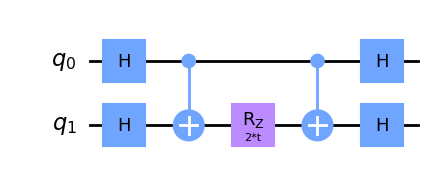

In [5]:
# Circuit for the XX(t) gate:

'''
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
'''

t = Parameter('t')

qc = QuantumCircuit(2, name='XX')
qc.h([0,1])
qc.cx(0, 1)
qc.rz(2 * t, 1)
qc.cx(0, 1)
qc.h([0,1])
qc.draw(output='mpl')

### Obtaining the XX(t) gate via spectral decomposition theorem

One should note that $e^{-itXX}$ is shorthand for $e^{-itX \otimes X}.$ Recall that Pauli operators are all involutory operators, i.e, their eigenvalues are $o_j = \pm 1$. According to the spectral decomposition theorem for Normal matrices, one then has:

$$X = \sum_{j=1}^{d} x_j |x_j \rangle \langle x_j| = |+\rangle\langle +|-|-\rangle\langle -|,$$

where $$ |\pm\rangle \equiv \frac{1}{\sqrt{2}}(|0\rangle\pm|1\rangle) $$ 

denotes the two orthonormal eigenstates (eigenvectors) of the Pauli $X$-gate according to:

$$X |+\rangle = \frac{1}{\sqrt{2}}(X|0\rangle+X|1\rangle)=\frac{1}{\sqrt{2}}(|1\rangle+|0\rangle)=|+\rangle,$$
$$X |-\rangle = \frac{1}{\sqrt{2}}(X|0\rangle-X|1\rangle) =\frac{1}{\sqrt{2}}(|1\rangle-|0\rangle)=-|-\rangle.$$

With that, one gets:

\begin{eqnarray}
XX &\equiv& X\otimes X = (|+\rangle\langle +|-|-\rangle\langle -|)\otimes(|+\rangle\langle +|-|-\rangle\langle -|) \tag{XX1}\\
&=& (|+\rangle\langle +|) \otimes (|+\rangle\langle +|) - (|+\rangle\langle +|) \otimes (|-\rangle\langle -|) - (|-\rangle\langle -|)\otimes (|+\rangle\langle +|) + (|-\rangle\langle -|) \otimes (|-\rangle\langle -|) \tag{XX2} \\
&=& (|++\rangle\langle ++|)-(|+-\rangle\langle +-|)-(|-+\rangle\langle -+|)+(|--\rangle\langle --|) \tag{XX3} \\
\implies e^{-itX \otimes X}
&=&e^{-it}|++\rangle\langle ++|+ e^{-it}|--\rangle\langle --|+e^{it}|+-\rangle\langle +-|+ e^{it}|-+\rangle\langle -+|\tag{XX4} \\
&=&e^{-it}\bigg(|++\rangle\langle ++|+|--\rangle\langle --|\bigg)+e^{it}\bigg(|+-\rangle\langle +-|+|-+\rangle\langle -+|\bigg).
\end{eqnarray}

- Eq. ($XX2$) was obtained from Eq. ($XX1$) using the distributive property for matrices:

$$(A+B) \otimes (C+D)=A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- Eq. ($XX3$) was obtained from Eq. ($XX2$) using:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle\langle cd|.$$

- Just as before, Eq. ($XX4$) is the result of acting an operator function (in this case $e^{i\theta \hat{O}}$) on a Normal matrix (in this case $X\otimes X$) represented by its corresponding spectral decomposition. 

As one can see, the $e^{-itX\otimes X}$ gate is not diagonalized in the $Z$-basis. Since measurements are computed in the $Z$-basis, one must apply a Hadamard gate to change between the $X$ and $Z$ bases according to

\begin{eqnarray}
|+\rangle &=& H|0\rangle = R_y(\pi/2)|0\rangle, \\
|-\rangle &=& H|1\rangle = R_y(-\pi/2)|0\rangle, \\
\langle +| &=& (|+\rangle)^{\dagger} = (H|0\rangle)^{\dagger} = (|0\rangle)^{\dagger}H^{\dagger} = \langle 0|H,\\
\langle -| &=& (|-\rangle)^{\dagger} == (H|1\rangle)^{\dagger} = (|1\rangle)^{\dagger}H^{\dagger} = \langle 1|H.
\end{eqnarray}

With that, and using $A |v\rangle \otimes B |w\rangle = (A\otimes B)(|v\rangle \otimes |w\rangle),$ one can write the respective outer products as follows:

\begin{eqnarray}
|++\rangle\langle ++| &=& (H|0\rangle \otimes H|0\rangle)(\langle 0| H \otimes \langle 0| H)\\
&=& \Bigg[(H \otimes H)(|0\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 0|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|00\rangle\langle 00|(H\otimes H),\\
\end{eqnarray}

\begin{eqnarray}
|--\rangle\langle --| &=& (H|1\rangle \otimes H|1\rangle)(\langle 1| H\otimes \langle 1| H)\\
&=& \Bigg[(H \otimes H)(|1\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 1|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|11\rangle\langle 11|(H\otimes H),
\end{eqnarray}

\begin{eqnarray}
|+-\rangle\langle +-| &=& (H|0\rangle \otimes H|1\rangle)(\langle 0| H \otimes \langle 1| H)\\
&=& \Bigg[(H \otimes H)(|0\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 1|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|01\rangle\langle 01|(H\otimes H),
\end{eqnarray}

\begin{eqnarray}
|-+\rangle\langle -+| &=& (H|1\rangle \otimes H|0\rangle)(\langle 1| H \otimes \langle 0| H)\\
&=& \Bigg[(H \otimes H)(|1\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 0|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|10\rangle\langle 10|(H\otimes H).
\end{eqnarray}

Finally,

\begin{eqnarray}
e^{-it X \otimes X} &=& e^{-it}\Bigg[(H\otimes H)|00\rangle\langle 00|(H\otimes H)+(H\otimes H)|11\rangle\langle 11|(H\otimes H)\Bigg]+e^{it}\Bigg[(H\otimes H)|01\rangle\langle 01|(H\otimes H)+(H\otimes H)|10\rangle\langle 10|(H\otimes H)\Bigg] \\
&=& (H\otimes H)\Bigg[e^{-it}\Bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\Bigg)+e^{it}\Bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\Bigg)\Bigg](H\otimes H)\\
&=& (H\otimes H) e^{-it Z \otimes Z}(H\otimes H) \\
&=& (H\otimes H) C_x^{01}\big(\mathbb{I}\otimes e^{-itZ}\big) C_x^{01}(H\otimes H) \\
&=& (H\otimes H) C_x^{01}\big(\mathbb{I}\otimes R_Z(2t)\big) C_x^{01}(H\otimes H),
\end{eqnarray}

where it was used the previously obtained decomposition of the $ZZ(t)$ gate, given by

\begin{eqnarray}
ZZ(t)=e^{-itZ\otimes Z} &=& e^{-it}\Bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\Bigg)+e^{it}\Bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\Bigg)=C_x^{01}\big(\mathbb{I}\otimes e^{-itZ}\big)C_x^{01},
\end{eqnarray}

and the fact that $e^{-itZ} = R_z(2t)$.

Q.E.D.

From the fact that 

$$H|0\rangle = R_y(\pi/2)|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \equiv |+\rangle,$$ 

and 

$$H|1\rangle = R_y(-\pi/2)|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \equiv |-\rangle,$$ 

one equivalent quantum circuit is:

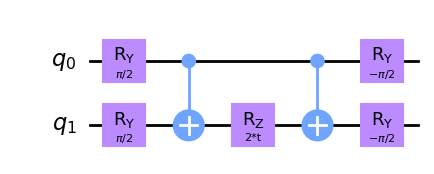

In [6]:
# Equivalent circuit for the XX(t) gate:

qc = QuantumCircuit(2, name='XX')
qc.ry(np.pi/2,[0,1])
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
qc.ry(-np.pi/2,[0,1])

qc.draw(output='mpl')

### Obtaining the XX(t) gate via single qubit rotations

Another method to obtain the $XX(t) \equiv e^{(-it X\otimes X)}$ gate is by performing single-qubit rotations on the $ZZ(t)$ gate. To this end, note that

$$R_y(\pi/2) Z R_y(-\pi/2) = X,$$

such that 

$$\Bigg(R_y(\pi/2) \otimes R_y(\pi/2) \Bigg) (Z\otimes Z) \Bigg(R_y(-\pi/2) \otimes R_y(-\pi/2) \Bigg) = X\otimes X.$$


The corresponding $XX(t)^{(0,1)}$ circuit acting on qubits 0 and 1 is then obtained by exponentiating the $Z\otimes Z$ operator in the equation above:

\begin{align}
\Bigg(R_y(\pi/2) \otimes R_y(\pi/2) \Bigg) e^{(-itZ\otimes Z)} \Bigg(R_y(-\pi/2) \otimes R_y(-\pi/2) \Bigg) =& \\
e^{-i \frac{\pi}{4}(Y\otimes I+I\otimes Y)} e^{(-itZ\otimes Z)} e^{i \frac{\pi}{4}(Y\otimes I+I\otimes Y)} =& \cdots \\
=& e^{(-it X\otimes X)} \\
\equiv& XX(t).
\end{align}

The full procedure can be found at [ibmq-qsim-sup-mat.ipynb](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-sup-mat.ipynb), where the following identity was used: 

$$R_{\hat{n}_j}(\theta_1) \otimes R_{\hat{n}_k}(\theta_2)=e^{-i(\hat{n}_j\cdot \vec{\sigma})\theta_1/2} \otimes e^{-i(\hat{n}_k\cdot \vec{\sigma})\theta_2/2} = e^{-\frac{i}{2}(\hat{\sigma}_j\theta_1 \otimes I+I \otimes \hat{\sigma}_k\theta_2)},$$

which follows from

$$e^A \otimes e^B=e^{A \otimes \mathbb{I}_n} e^{\mathbb{I}_m \otimes B}=e^{A \otimes \mathbb{I}_n + \mathbb{I}_m \otimes B}.$$

## $YY(t)$ gate

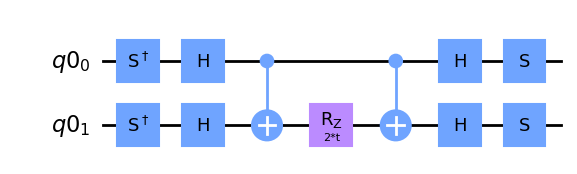

In [7]:
# Circuit for the YY(t) gate:

'''
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
'''

t = Parameter('t')

qr = QuantumRegister(2)
qc = QuantumCircuit(qr, name='YY')
qc.sdg([0,1])
qc.h([0,1])
qc.cx(0, 1)
qc.rz(2 * t, 1)
qc.cx(0, 1)
qc.h([0,1])
qc.s([0,1])
qc.draw(output='mpl')

One should note that $e^{-itYY}$ is shorthand for $e^{-itY \otimes Y}$. Following the same thought process as before, one writes the spectral decomposition of the Pauli operator $Y$ in the basis of its eigenvectors:

$$Y=\sum_{j=1}^{d} y_j |y_j \rangle \langle y_j|=|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|,$$

where

\begin{eqnarray}
|+y\rangle &\equiv& |\oplus\rangle \doteq \frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle), \\
|-y\rangle &\equiv& |\ominus\rangle \doteq \frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle),
\end{eqnarray}

denotes the two orthonormal eigenstates (eigenvectors) of the Pauli $Y$-gate. 

With that, one has

\begin{eqnarray}
YY &\equiv& Y \otimes Y = (|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|)\otimes(|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|) \tag{YY1}\\
&=& (|\oplus\rangle\langle \oplus|) \otimes (|\oplus\rangle\langle \oplus|) - (|\oplus\rangle\langle \oplus|) \otimes (|\ominus\rangle\langle \ominus|) - (|\ominus\rangle\langle \ominus|)\otimes(|\oplus\rangle\langle \oplus|) + (|\ominus\rangle\langle \ominus|)\otimes(|\ominus\rangle\langle \ominus|) \tag{YY2}\\
&=&|\oplus\oplus\rangle\langle \oplus\oplus|-|\oplus\ominus\rangle\langle \oplus\ominus|-|\ominus\oplus\rangle\langle \ominus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus| \tag{YY3}.
\end{eqnarray}

- Eq. ($YY2$) was obtained from Eq. ($YY1$) using the distributive property for matrices:

$$(A+B) \otimes (C+D)=A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- Eq. ($YY3$) was obtained from Eq. ($YY2$) using:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle\langle cd|.$$

Henceforth, 

\begin{eqnarray}
e^{-itY \otimes Y}&=&e^{-it}|\oplus\oplus\rangle\langle \oplus\oplus|+ e^{it}|\oplus\ominus\rangle\langle \oplus\ominus|+ e^{it}|\ominus\oplus\rangle\langle \ominus\oplus|+e^{-it}|\ominus\ominus\rangle\langle \ominus\ominus|\tag{YY4} \\
&=&e^{-it}\Bigg(|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|\Bigg) + e^{it}\Bigg(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|\Bigg).
\end{eqnarray}

- Once more, Eq. ($YY4$) is the result of acting an operator function (in this case $e^{i\theta \hat{O}}$) on a Normal matrix (in this case $Y\otimes Y$) with the spectral decomposition, according to:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|.$$

As one can see, the $e^{-itY\otimes Y}$ gate is not diagonalized in the $Z$-basis. Since measurements are computed in the $Z$-basis, the next step is to apply a basis change, as follows:

\begin{eqnarray}
|\oplus\rangle &=& SH|0\rangle = R_x(-\pi/2)|0\rangle, \\
|\ominus\rangle &=& SH|1\rangle = R_x(\pi/2)|0\rangle, \\
\langle \oplus| &=& (|\oplus\rangle)^{\dagger} = (SH|0\rangle)^{\dagger} = (|0\rangle)^{\dagger} (SH)^{\dagger} = \langle 0| H^{\dagger}S^{\dagger}=\langle 0|HS^{\dagger},\\
\langle \ominus| &=& (|\ominus\rangle)^{\dagger} = (SH|1\rangle)^{\dagger} = (|1\rangle)^{\dagger} (SH)^{\dagger} = \langle 1| H^{\dagger}S^{\dagger}=\langle 1|HS^{\dagger}.
\end{eqnarray}

With that, and using $A |v\rangle \otimes B |w\rangle = (A\otimes B)(|v\rangle \otimes |w\rangle),$ one can write the respective outer products as follows:

\begin{eqnarray}
|\oplus\oplus\rangle\langle \oplus\oplus| &=& (SH|0\rangle \otimes SH|0\rangle)(\langle 0| HS^{\dagger} \otimes \langle 0| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|0\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 0|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|00\rangle\langle 00|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}),
\end{eqnarray}

\begin{eqnarray}
|\ominus\ominus\rangle\langle \ominus\ominus| &=& (SH|1\rangle \otimes SH|1\rangle)(\langle 1| HS^{\dagger} \otimes \langle 1| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|1\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 1|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|11\rangle\langle 11|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}),
\end{eqnarray}

\begin{eqnarray}
|\oplus\ominus\rangle\langle \oplus\ominus| &=& (SH|0\rangle \otimes SH|1\rangle)(\langle 0| HS^{\dagger} \otimes \langle 1| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|0\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 1|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|01\rangle\langle 01|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}),
\end{eqnarray}

\begin{eqnarray}
|\ominus\oplus\rangle\langle \ominus\oplus| &=& (SH|1\rangle \otimes SH|0\rangle)(\langle 1| HS^{\dagger} \otimes \langle 0| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|1\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 0|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|10\rangle\langle 10|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).
\end{eqnarray}

Finally,

\begin{eqnarray}
e^{-itY\otimes Y} &=& e^{-it}\Bigg((S\otimes S)(H\otimes H)|00\rangle\langle 00|(H\otimes H)(S^{\dagger}\otimes S^{\dagger})+(S\otimes S)(H\otimes H)|11\rangle\langle 11|(H\otimes H) (S^{\dagger}\otimes S^{\dagger})\Bigg) \\
&+& e^{it}\Bigg((S\otimes S) (H\otimes H)|01\rangle\langle 01|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) + (S\otimes S)(H\otimes H)|10\rangle\langle 10|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \Bigg)\\
&=& (S\otimes S)(H\otimes H) \Bigg[e^{-it}\Bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\Bigg)+e^{it} \Bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\Bigg)\Bigg](H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& =& (S\otimes S) (H\otimes H)e^{-itZ \otimes Z}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
&=&(S \otimes S) (H \otimes H) C_x^{01}\big(\mathbb{I}\otimes e^{-itZ}\big) C_x^{01} (H \otimes H) (S^{\dagger} \otimes S^{\dagger}) \\
&=& (S \otimes S) (H \otimes H) C_x^{01} \big(\mathbb{I}\otimes R_z(2t)\big) C_x^{01} (H \otimes H) (S^{\dagger} \otimes S^{\dagger}).
\end{eqnarray}

Where it was used the previously obtained result for the decomposition of the $ZZ(t)=e^{-itZ\otimes Z}$ gate and the equality $e^{-itZ} = R_z(2t)$.

Q.E.D.

From the fact that 

$$SH|0\rangle = R_x(-\pi/2)|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle) \equiv |\oplus\rangle,$$ 

and 

$$SH|1\rangle = R_x(\pi/2)|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle) \equiv |\ominus\rangle,$$ 

one equivalent quantum circuit is:

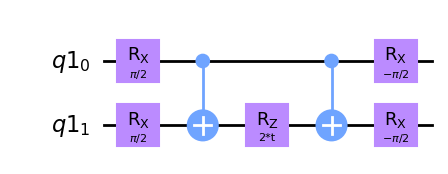

In [8]:
# Equivalent circuit for the YY(t) gate:

qr = QuantumRegister(2)
qc = QuantumCircuit(qr, name='YY')
qc.rx(np.pi/2,[0,1])
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
qc.rx(-np.pi/2,[0,1])

qc.draw(output='mpl')

# About the Trotterized Evolution

Consider the trotterized circuit below. Is it possible to change the order of the two-qubit gates in this circuit?

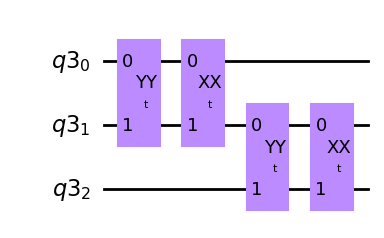

In [9]:
t = Parameter('t')
qr = QuantumRegister(2)

ZZ_qc = QuantumCircuit(qr, name='ZZ')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)
ZZg = ZZ_qc.to_instruction()

XX_qc = QuantumCircuit(qr, name='XX')
XX_qc.h([0,1])
XX_qc.append(ZZg, [0,1])
XX_qc.h([0,1])
XXg = XX_qc.to_instruction()

YY_qc = QuantumCircuit(qr, name='YY')
YY_qc.sdg([0,1])
YY_qc.h([0,1])
YY_qc.append(ZZg, [0,1])
YY_qc.h([0,1])
YY_qc.s([0,1])
YYg = YY_qc.to_instruction()

num_qubits = 3
Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
for i in range(0, num_qubits - 1):
    Trot_qc.append(YYg, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XXg, [Trot_qr[i], Trot_qr[i+1]])
Trot_gate = Trot_qc.to_instruction()
Trot_qc.draw(output='mpl')

The unitary operator for the circuit above reads (little-endian convention):

\begin{eqnarray}
U(\Delta t) &=& (e^{-i \Delta t (X_2 \otimes X_1)}\otimes \mathbb{I}_0) (e^{-i \Delta t (Y_2 \otimes Y_1)}\otimes \mathbb{I}_0) (\mathbb{I}_2\otimes e^{-i \Delta t (X_1\otimes X_0)}) (\mathbb{I}_2 \otimes e^{-i \Delta t (Y_1\otimes Y_0)})\\ 
&=& e^{-i \Delta t (X_2 \otimes X_1 \otimes \mathbb{I}_0)} e^{-i \Delta t (Y_2 \otimes Y_1 \otimes \mathbb{I}_0)} e^{-i \Delta t (\mathbb{I}_2\otimes X_1\otimes X_0)} e^{-i \Delta t (\mathbb{I}_2 \otimes Y_1\otimes Y_0)},
\end{eqnarray}

where it was used $e^{A\otimes \mathbb{I}} = e^{A}\otimes \mathbb{I}$.

Moreover, (for $j\neq k$):

$$[\sigma_j\otimes\sigma_j,\sigma_k\otimes\sigma_k]=\mathbb{O},$$

meaning that
$$[X \otimes X, Y \otimes Y] = [X \otimes X, Z \otimes Z] = [Y \otimes Y, Z \otimes Z]=\mathbb{O}.$$

And since $e^Ae^B=e^{A+B}$ iff $[A,B] = \mathbb{O}$, one then has

$$e^{-i\Delta t X\otimes X\otimes \mathbb{I}}e^{-i\Delta tY\otimes Y\otimes \mathbb{I}} = e^{-i \Delta t(X\otimes X\otimes \mathbb{I} + Y\otimes Y\otimes \mathbb{I})},$$

hence

$$e^{-i \Delta t X\otimes X \otimes \mathbb{I}} e^{-i \Delta t Y\otimes Y \otimes \mathbb{I}} = e^{-i \Delta t Y\otimes Y \otimes \mathbb{I}}  e^{-i \Delta t X\otimes X \otimes \mathbb{I}}.$$

However, one should also note that (for $j\neq k$):

$$[\sigma_j\otimes\sigma_j\otimes\sigma_0,\sigma_0\otimes\sigma_k\otimes\sigma_k] \ne \mathbb{O},$$

so that
\begin{eqnarray}
e^{-i\Delta t (Y\otimes Y \otimes \mathbb{I}+\mathbb{I}\otimes X\otimes X)} &\neq& e^{-i\Delta t Y\otimes Y\otimes \mathbb{I}} e^{-i\Delta t \mathbb{I}\otimes X\otimes X},
\end{eqnarray}

hence

\begin{eqnarray}
e^{-i\Delta t Y\otimes Y \otimes \mathbb{I}}e^{-i\Delta t\mathbb{I} \otimes X \otimes X} &\ne& e^{-i\Delta t\mathbb{I}\otimes X \otimes X}e^{-i\Delta t Y \otimes Y \otimes \mathbb{I}}.
\end{eqnarray}

### **Verifying with NumPy:**

$$e^{-i\Delta t (X\otimes X \otimes \mathbb{I} + Y\otimes Y \otimes \mathbb{I})} = e^{-i\Delta t X\otimes X \otimes \mathbb{I}}e^{-i\Delta t Y\otimes Y \otimes \mathbb{I}}:$$

Obs: setting $\Delta t=1$.

In [10]:
XXI = np.kron(XX, sigma0)
YYI = np.kron(YY, sigma0)

(expm(-1j*(XXI+YYI)).round(6) == (expm(-1j*XXI)@expm(-1j*YYI)).round(6)).all()

True

$$ e^{-i \Delta t X\otimes X \otimes \mathbb{I}} e^{-i \Delta t Y\otimes Y \otimes \mathbb{I}} = e^{-i \Delta t Y\otimes Y \otimes \mathbb{I}}  e^{-i \Delta t X\otimes X \otimes \mathbb{I}}:$$

Obs: setting $\Delta t=1$.

In [11]:
((expm(-1j*XXI)@expm(-1j*YYI)).round(6) == (expm(-1j*YYI)@expm(-1j*XXI)).round(6)).all()

True

$$e^{-i\Delta t (Y\otimes Y \otimes \mathbb{I}+\mathbb{I}\otimes X\otimes X)} \ne e^{-i\Delta t Y\otimes Y\otimes \mathbb{I}} e^{-i\Delta t \mathbb{I}\otimes X\otimes X}:$$

Obs: setting $\Delta t=1$.

In [12]:
'''Return should be >>> False.'''

YYI = np.kron(YY, sigma0)
IXX = np.kron(sigma0, XX)

(expm(-1j*(YYI+IXX)).round(6) == (expm(-1j*YYI)@expm(-1j*IXX)).round(6)).all()

False

### **Verifying with Qiskit Opflow:**

$$e^{-i\Delta t (X\otimes X \otimes \mathbb{I} + Y\otimes Y \otimes \mathbb{I})} = e^{-i\Delta t X\otimes X \otimes \mathbb{I}}e^{-i\Delta t Y\otimes Y \otimes \mathbb{I}}:$$

Obs: setting $\Delta t=1$.

In [13]:
from qiskit.opflow import I, X, Y, Z

H1 = (X^X^I)+(Y^Y^I)
(H1.exp_i().to_matrix().round(7) == ((X^X^I).exp_i()@(Y^Y^I).exp_i()).to_matrix().round(7)).all()

True

$$e^{-i\Delta t (Y\otimes Y \otimes \mathbb{I}+\mathbb{I}\otimes X\otimes X)} \ne e^{-i\Delta t Y\otimes Y\otimes \mathbb{I}} e^{-i\Delta t \mathbb{I}\otimes X\otimes X}:$$

Obs: setting $\Delta t=1$.

In [14]:
'''Return should be >>> False.'''

H2 = (Y^Y^I)+(I^X^X)
(H2.exp_i().to_matrix().round(3) == ((Y^Y^I).exp_i()@(I^X^X).exp_i()).to_matrix().round(3)).all()

False

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/book" width="45" hspace="0px" vspace="0px"></a> References

[1] Nielsen MA, Chuang IL. 2010. Quantum Computation and Quantum Information. New York: [Cambridge Univ. Press.](https://doi.org/10.1017/CBO9780511976667) 10th Anniv. Ed.  

[2] Horn, R., & Johnson, C. (1991). Frontmatter. In Topics in Matrix Analysis (pp. I-Iv). [Cambridge: Cambridge University Press](https://www.cambridge.org/core/books/topics-in-matrix-analysis/B988495A235F1C3406EA484A2C477B03).

